# Topic Modeling
### First attempt
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

In [2]:
# Importing modules
import gensim
import nltk
import os
import string
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [4]:
# Read data into papers
data = pd.read_csv('D:\\Alerta Backup Data\\gonzalo_data\\datasets\\text\\data_clean_large.csv', sep=';')
data = data.dropna(subset=['text'])
data = data[data['class'] == 0]
# Print head
data.head()

,class,text,image
0,0,© From your Google Drive Interview-Mode BK99 S...,focused_Algorithms_one_0.jpg
1,0,=] Computatior] ] + File Edit View Insert Form...,focused_Algorithms_one_1.jpg
2,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_10.jpg
3,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_100.jpg
4,0,= 401 Computational Geometry File Edit View ...,focused_Algorithms_one_101.jpg


In [20]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
stop_words.extend(["edit", "file", "view", "google", "tools", "help", "format", "insert", "tab", "bk", "ses", "es"])
stop_words.extend(['canvas', 'sion', 'oc', 'go', 'oe', 'drive', 'web', 'store', 'add', 'shortcut', 'gm', 'image', 'account', 'dashboard', 'calendar', 'commons', 'ie', 'assignments', 'adob', 'mec', 'hal', 'adi', 'je', 'alg', 'session', 'ra', 'eativ', 'ort', 'cmsc', 'cor', 'lecture', 'share', 'new', 'ee', 'due', 'monday', 'prr', 'none', 'next', 'pre', 'make', 'text', 'question', 'also', 'would', 'one', 'two', 'three', 'four', 'know', 'good', 'bad', 'get', 'normal', 'like', 'email', 'inbox', 'vcu', 'aa', 'notes', 'use', 'exam', 'may', 'us', 'oo', 'untitled', 'slide', 'part', 'work', 'search', 'na', 'ae', 'answer', 'solution', 'lc', 'arial', 'month', 'files', 'test' 'doc', 'day', 'cc', 'see', 'able', 'define', 'last', 'used', 'eb', 'pm', 'first', 'status', 'doc', 'home', 'must', 'many', 'things', 'dont', 'site', 'lc', 'el', 'edited', 'much', 'size', 'zoom'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gonzalo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
#Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of accents
    doc = doc.encode('ascii', 'ignore').decode('ascii')
    # Removal of whitespaces
    doc = " ".join(doc.split())
    # Lowercasing
    return doc.lower()

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        nouns = []
        for word,pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
            if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
                nouns.append(word)
        yield(nouns)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [22]:
text = data.dropna(subset=['text']).text
words = list(sent_to_words([clean(doc) for doc in text]))
data_words = remove_stopwords(words)
print(data_words[:1][0][:30])

['interviewmode', 'geometry', 'geometry', 'signme', 'points']


In [23]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1)]


In [75]:
coherence = []
for k in range(3,20):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus, id2word=id2word, num_topics=k, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19


LDA requires specifying the number of topics. We can tune this through optimization of measures such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing a coherence measure, named Cv [1], leads to better human interpretability. We can test out a number of topics and asses the Cv measure: https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

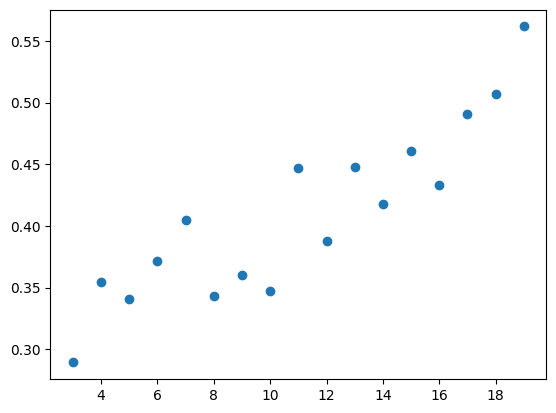

In [76]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*coherence))
plt.show()

In [24]:
from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"point" + 0.006*"points" + 0.006*"numbers" + 0.006*"line" + '
  '0.006*"equation" + 0.005*"side" + 0.005*"hull" + 0.005*"extensions" + '
  '0.005*"convex" + 0.005*"structure"'),
 (1,
  '0.014*"edge" + 0.005*"people" + 0.004*"ge" + 0.004*"time" + 0.004*"node" + '
  '0.004*"extensions" + 0.004*"weight" + 0.004*"set" + 0.003*"review" + '
  '0.003*"data"'),
 (2,
  '0.020*"team" + 0.010*"members" + 0.006*"review" + 0.004*"groupthink" + '
  '0.004*"average" + 0.004*"bone" + 0.004*"locus" + 0.004*"control" + '
  '0.004*"people" + 0.004*"information"'),
 (3,
  '0.012*"time" + 0.007*"point" + 0.006*"attempts" + 0.005*"design" + '
  '0.005*"variation" + 0.004*"questions" + 0.004*"hours" + 0.004*"points" + '
  '0.004*"ph" + 0.003*"ml"'),
 (4,
  '0.011*"edge" + 0.007*"video" + 0.006*"brain" + 0.006*"time" + '
  '0.005*"systems" + 0.005*"extensions" + 0.004*"revenue" + 0.004*"edges" + '
  '0.004*"set" + 0.004*"people"'),
 (5,
  '0.010*"rights" + 0.007*"people" + 0.006*"world" + 0.005*

In [25]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = 'ldavis_prepared_'+str(num_topics)

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.049184  0.054472       1        1  7.427571
11    -0.023206  0.061370       2        1  6.922947
5      0.023478  0.010166       3        1  6.540118
4     -0.017587  0.075661       4        1  6.340065
13     0.024995 -0.014045       5        1  6.304345
2     -0.106102 -0.010790       6        1  6.277110
12     0.006288 -0.011274       7        1  6.187006
18    -0.021331  0.012800       8        1  5.608319
16     0.054665  0.044395       9        1  5.184116
0      0.054239 -0.055157      10        1  5.071738
1      0.015594  0.040132      11        1  4.755098
3     -0.000736 -0.031827      12        1  4.667173
8     -0.026741 -0.007662      13        1  4.327692
19     0.067683 -0.068536      14        1  4.280240
6      0.004894  0.012842      15        1  3.977435
15     0.029227 -0.020901      16        1  3.519969
7      0.025617  0.000536      17        1  3.476025
9     -0.071941 -0.008845      18        1  3.459904
17    -0.046153 -0.031570      19        1  3.153319
14    -0.042066 -0.051767      20        1  2.519810, topic_info=             Term         Freq        Total Category  logprob  loglift
738          edge  1706.000000  1706.000000  Default  30.0000  30.0000
1673         team  2260.000000  2260.000000  Default  29.0000  29.0000
13552     vectors   976.000000   976.000000  Default  28.0000  28.0000
2953      average   838.000000   838.000000  Default  27.0000  27.0000
2406      numbers   942.000000   942.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2394      control    46.774559  1519.172014  Topic20  -6.1304   0.2004
198           way    47.062167  1594.748057  Topic20  -6.1242   0.1580
1457         life    48.489846  1852.565382  Topic20  -6.0943   0.0380
43     management    44.577140  1685.002271  Topic20  -6.1785   0.0487
572         media    41.682854  1884.589801  Topic20  -6.2456  -0.1304

[1733 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
33642      3  0.036354       aagen
33642      5  0.072707       aagen
33642      6  0.072707       aagen
33642     12  0.072707       aagen
33642     13  0.036354       aagen
...      ...       ...         ...
10463     19  0.010882  youtubecom
10463     20  0.065295  youtubecom
43514      3  0.636790  yovifvevye
12649      6  0.247553        yvon
12649     19  0.495105        yvon

[12135 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 6, 5, 14, 3, 13, 19, 17, 1, 2, 4, 9, 20, 7, 16, 8, 10, 18, 15])